## Retention

In [1]:
##Import the relevant libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt
from scipy.stats import norm
import sqlite3 as sql

In [2]:
#read the file
activity=pd.read_csv('data/data_daily_activity.csv')

Lets explore the data to see how it looks like and confirm if we can perform reliable statistical analysis on it

In [3]:
activity.head(5)

,userId,date,countryCode,platform,abTestGroup
0,j83udscs5b5bfmb,2020-05-03,FR,ios,test_group_a
1,6vmia2xkmuo7ubm,2020-05-10,BR,ios,test_group_a
2,kov82tsj6he7hvp,2020-05-12,BR,android,control_group
3,85el8huhiwealui,2020-05-11,GB,android,test_group_b
4,i13ac0rsxzk9ueh,2020-05-14,AW,ios,test_group_a


In [4]:
activity.info()
activity.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236376 entries, 0 to 236375
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   userId       236376 non-null  object
 1   date         236376 non-null  object
 2   countryCode  236336 non-null  object
 3   platform     236376 non-null  object
 4   abTestGroup  236376 non-null  object
dtypes: object(5)
memory usage: 9.0+ MB


,userId,date,countryCode,platform,abTestGroup
count,236376,236376,236336,236376,236376
unique,108772,15,192,2,3
top,1ey0x4awofv818n,2020-05-15,BR,android,test_group_b
freq,15,19121,29319,167808,79052


In [5]:
activity.groupby('abTestGroup')['userId'].nunique()

abTestGroup
control_group    36253
test_group_a     35942
test_group_b     36577
Name: userId, dtype: int64

The sample sizes are within an acceptable range of each other (About 1%)

Let's add an acquisition date column to our data

In [6]:
activity.set_index('userId', inplace=True, drop=False)
activity['aq_date'] = activity.groupby(level=0)['date'].min()

In [7]:
activity.groupby(['aq_date', 'abTestGroup']).size()

aq_date     abTestGroup  
2020-05-01  control_group    8340
            test_group_a     8546
            test_group_b     9036
2020-05-02  control_group    7857
            test_group_a     8563
            test_group_b     7795
2020-05-03  control_group    8313
            test_group_a     8758
            test_group_b     8217
2020-05-04  control_group    6925
            test_group_a     6699
            test_group_b     6465
2020-05-05  control_group    6296
            test_group_a     6134
            test_group_b     5839
2020-05-06  control_group    4943
            test_group_a     4573
            test_group_b     4734
2020-05-07  control_group    4856
            test_group_a     4653
            test_group_b     5156
2020-05-08  control_group    5277
            test_group_a     4845
            test_group_b     5115
2020-05-09  control_group    5195
            test_group_a     5144
            test_group_b     5385
2020-05-10  control_group    5157
            test_group

We will now use cohort analysis to calculate retention rates. This will help us find the retention rate at Day N for a range of different values of N. The first step is to assign seniority to each activity day. Seniority is the difference between current activity date and the acquisition date of a particular customer.

In [8]:
activity.aq_date = pd.to_datetime(activity.aq_date, format='%Y-%m-%d')
activity.date = pd.to_datetime(activity.date, format='%Y-%m-%d')
activity['seniority'] = (activity['date'] - activity['aq_date']).dt.days + 1

In [9]:
def cohort_analysis(df, color):   
    group = df.groupby(['aq_date', 'seniority'])
    cohort_data = group['userId'].size()
    cohort_data = cohort_data.reset_index()
    cohort_counts = cohort_data.pivot(index='aq_date', columns='seniority', values='userId')
    base = cohort_counts[1]
    retention = cohort_counts.divide(base, axis=0).round(3)
    plt.figure(figsize=(18,14))
    plt.title('Retention Table')
    ax = sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=1,cmap=color)
    ax.set_yticklabels(retention.index)
    fig=ax.get_figure()
    fig.savefig("Retention_Rate.png")
    plt.show()
    return retention, cohort_counts

In [10]:
group_control=activity[activity['abTestGroup']=='control_group']
group_A=activity[activity['abTestGroup']=='test_group_a']
group_B=activity[activity['abTestGroup']=='test_group_b']

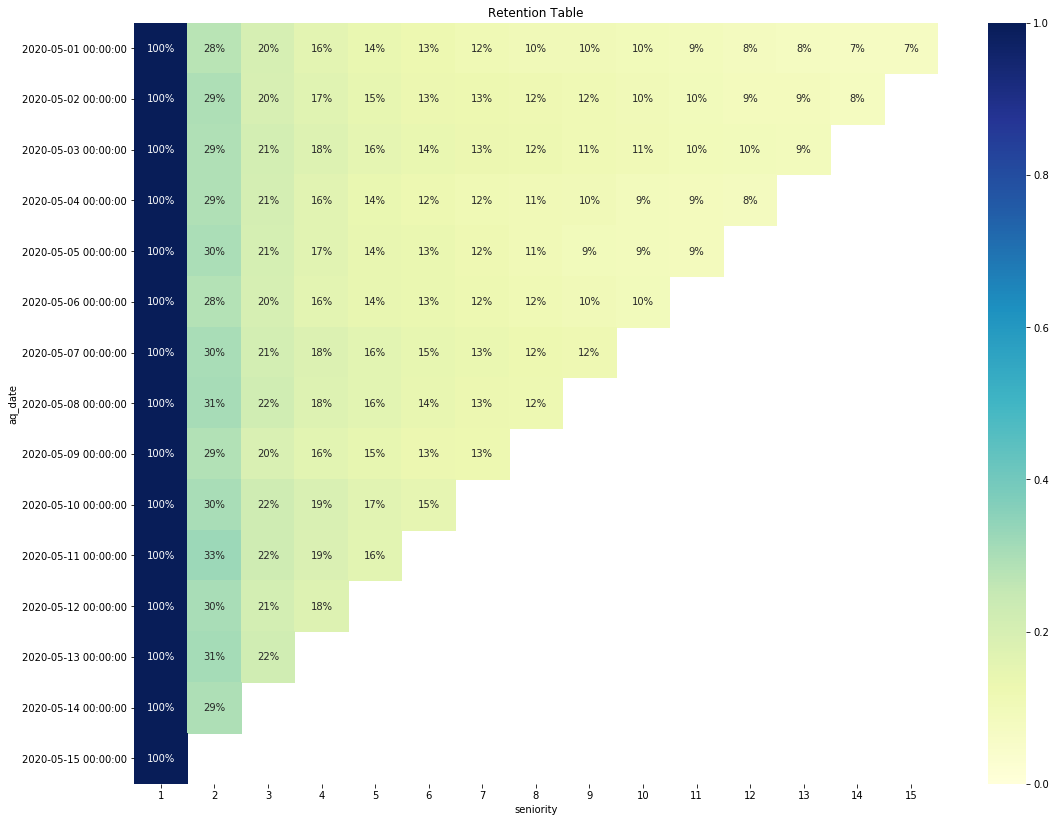

In [11]:
all_retention,all_counts=cohort_analysis(activity,'YlGnBu')

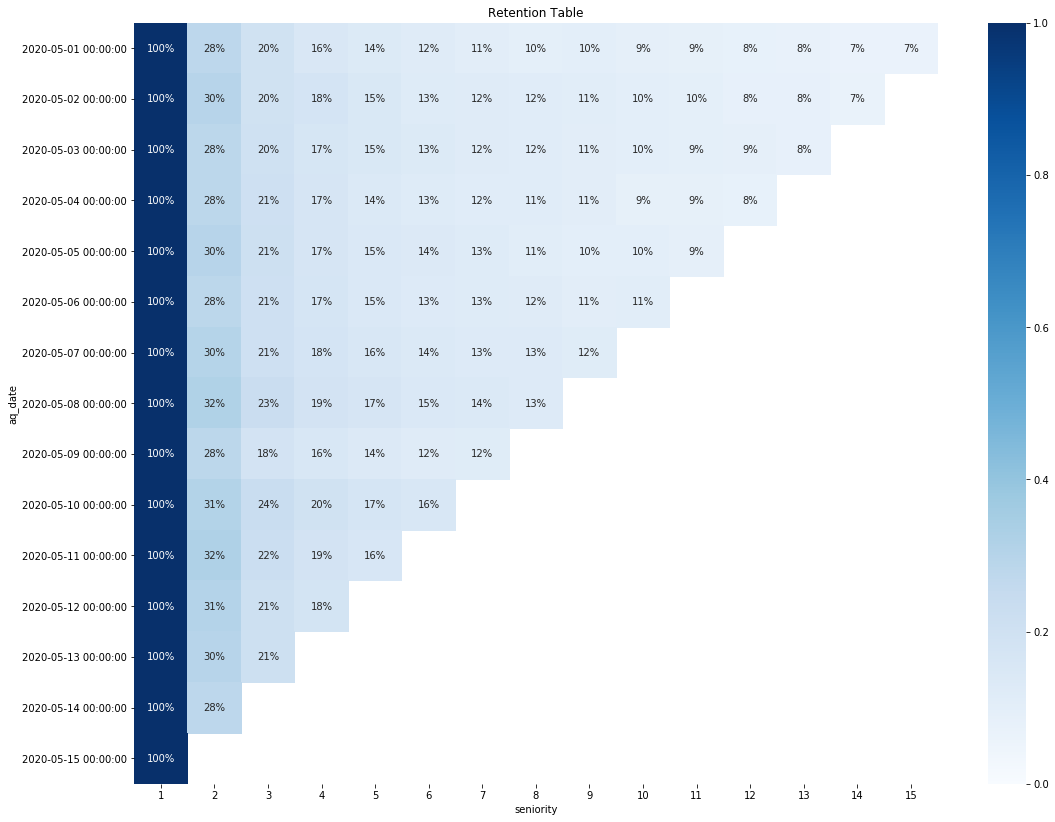

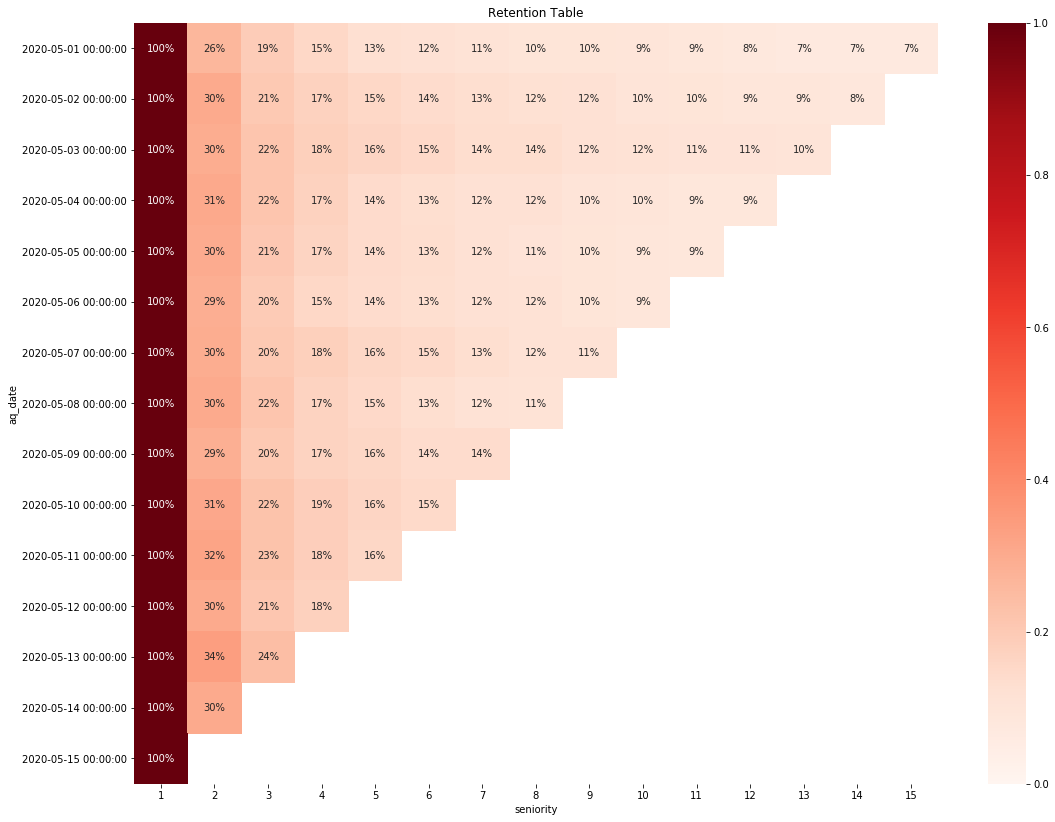

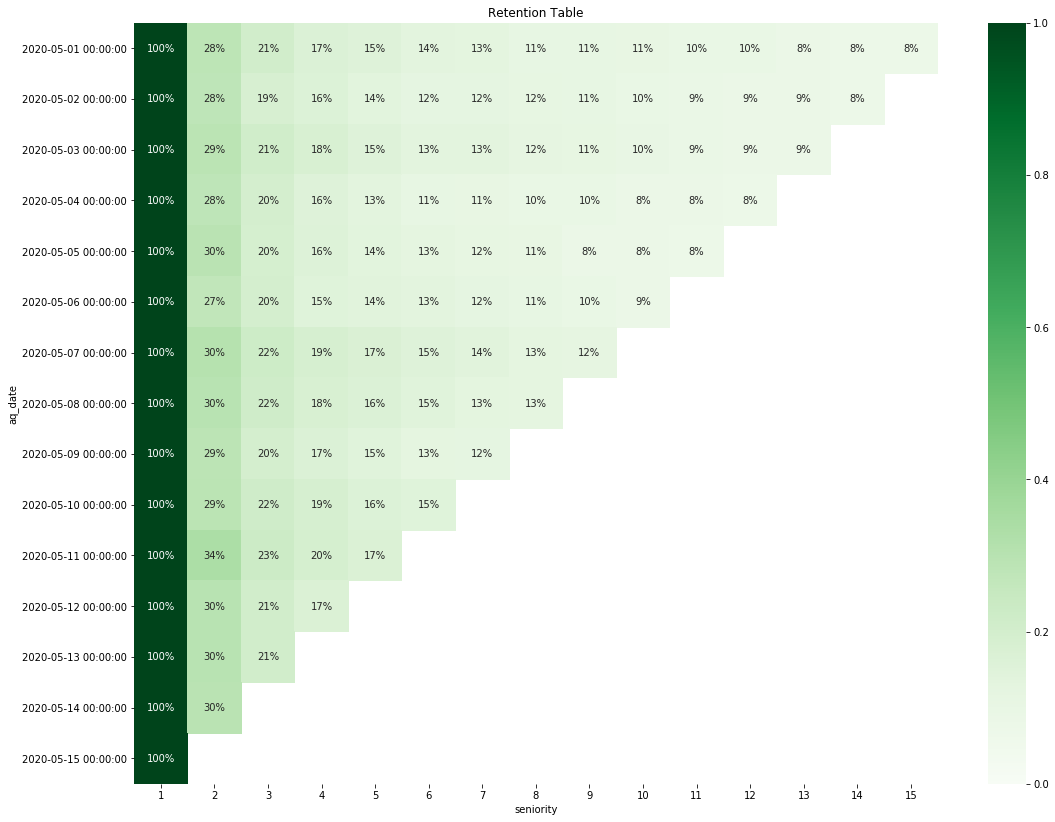

In [12]:
c_retention,c_counts=cohort_analysis(group_control, 'Blues')
a_retention, a_counts=cohort_analysis(group_A, 'Reds')
b_retention, b_counts=cohort_analysis(group_B, 'Greens')

Let's look at how retention rates of the different groups vary from each other over different values of N

In [13]:
x=np.sort(activity['seniority'].unique())

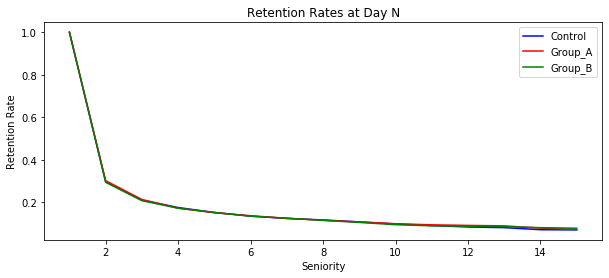

In [14]:
plt.figure(figsize=(10,4))
plt.xlabel('Seniority')
plt.ylabel('Retention Rate')
plt.title('Retention Rates at Day N')
plt.plot(x,c_retention.mean(), color="b")
plt.plot(x,a_retention.mean(), color="r")
plt.plot(x,b_retention.mean(), color="g")
plt.legend(['Control', 'Group_A', 'Group_B'])
plt.show()

Let's test the significance of the difference in retention rates through a t value test

In [15]:
def hypothesis_test(N):
    M=15-N
    #Calculate the difference in retention rates for this specific value of N
    diff_a=round((a_counts[N].sum()/a_counts[1][0:M].sum())-(c_counts[N].sum()/c_counts[1][0:M].sum()),4)
    diff_b=round((b_counts[N].sum()/b_counts[1][0:M].sum())-(c_counts[N].sum()/c_counts[1][0:M].sum()),4)
    #calculate the pooled standard deviation
    sd_a=(a_counts[N].sum()+c_counts[N].sum())/(a_counts[1][0:M].sum()+c_counts[1][0:M].sum())
    sd_b=(b_counts[N].sum()+c_counts[N].sum())/(b_counts[1][0:M].sum()+c_counts[1][0:M].sum())
    se_a=round(mt.sqrt(sd_a*(1-sd_a)*(1/a_counts[1][0:M].sum()+1/c_counts[1][0:M].sum())))
    se_b=round(mt.sqrt(sd_b*(1-sd_b)*(1/b_counts[1][0:M].sum()+1/c_counts[1][0:M].sum())))
    
    #marginal_error
    alpha=0.05
    #z-value for 95% confidence interval
    z=round(norm.ppf(1-alpha/2),2)
    #marginal error calculation
    merror_a=round((z*se_a),4)
    merror_b=round((z*se_b),4)
    
    tvalue_a=diff_a-merror_a
    tvalue_b=diff_b-merror_b
    print("t value for sample a: ",tvalue_a)
    print("t value for sample b: ", tvalue_b)

In [17]:
hypothesis_test(8)

t value for sample a:  -0.0004
t value for sample b:  -0.0013


In [18]:
hypothesis_test(2)

t value for sample a:  0.0053
t value for sample b:  -0.0018


## Matches Played

In [19]:
#read the matches file
matches=pd.read_csv('data/data_daily_matches.csv')

In [20]:
#create a table with unique values
user_aq=activity.drop_duplicates(['userId','aq_date','abTestGroup'])[['userId','aq_date','abTestGroup']]

In [21]:
#add these columns to the matches table
matches.index.name = None
user_aq.index.name= None
match_df=matches.merge(user_aq,left_on='userId',right_on='userId',how='left')[['userId','aq_date','abTestGroup','date','matches']]

In [22]:
#add a seniority column
match_df.date = pd.to_datetime(match_df.date, format='%Y-%m-%d')
match_df.aq_date = pd.to_datetime(match_df.aq_date, format='%Y-%m-%d')
match_df['seniority'] = (match_df['date'] - match_df['aq_date']).dt.days + 1

In [23]:
#filter to user who had atleast 7 days after acquisition within our data period
match_df=match_df[(match_df['aq_date'] >= '2020-05-01') & (match_df['aq_date'] <= '2020-05-08')]
match_df=match_df[match_df['seniority']<=8]

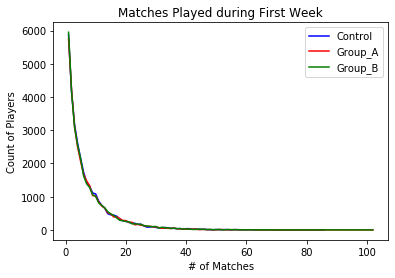

In [24]:
#plot our results
%matplotlib inline
c=match_df[match_df['abTestGroup']=='control_group']
a=match_df[match_df['abTestGroup']=='test_group_a']
b=match_df[match_df['abTestGroup']=='test_group_b']

#Counting the number of players for each number of gamerounds 
match_counts_a=a.groupby(['userId','aq_date','abTestGroup','seniority'], as_index=False)['matches'].sum()
plot_df_a = match_counts_a.groupby('matches').count().reset_index()

match_counts_b=b.groupby(['userId','aq_date','abTestGroup','seniority'], as_index=False)['matches'].sum()
plot_df_b= match_counts_b.groupby('matches').count().reset_index()

match_counts_c=c.groupby(['userId','aq_date','abTestGroup','seniority'], as_index=False)['matches'].sum()
plot_df_c= match_counts_c.groupby('matches').count().reset_index()

x_c=plot_df_c.head(n=100)['matches'].unique()
x_a=plot_df_a.head(n=100)['matches'].unique()
x_b=plot_df_b.head(n=100)['matches'].unique()


plt.xlabel("# of Matches")
plt.ylabel("Count of Players")
plt.title("Matches Played during First Week")
plt.plot(x_c,plot_df_c.head(n=100)['userId'], color="b")
plt.plot(x_a,plot_df_a.head(n=100)['userId'], color="r")
plt.plot(x_b,plot_df_b.head(n=100)['userId'], color="g")
plt.legend(['Control', 'Group_A', 'Group_B'])




## Revenue

In [25]:
#read the file
purchases=pd.read_csv('data/data_in_app_purchases.csv')
##remove rows where cost is null
bool_series = pd.notnull(purchases["cost"])  
purchases=purchases[bool_series]
##add test group, aq_date and seniority columns to purchases
purchases_df=purchases.merge(user_aq,left_on='userId',right_on='userId',how='left')[['userId','aq_date','date','abTestGroup','product','cost']].reset_index()
purchases_df.aq_date = pd.to_datetime(purchases_df.aq_date, format='%Y-%m-%d')
purchases_df.date = pd.to_datetime(purchases_df.date, format='%Y-%m-%d')
purchases_df['seniority'] = (purchases_df['date'] - purchases_df['aq_date']).dt.days + 1
purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20040 entries, 0 to 20039
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        20040 non-null  int64         
 1   userId       20040 non-null  object        
 2   aq_date      20040 non-null  datetime64[ns]
 3   date         20040 non-null  datetime64[ns]
 4   abTestGroup  20040 non-null  object        
 5   product      20040 non-null  object        
 6   cost         20040 non-null  float64       
 7   seniority    20040 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 1.2+ MB


In [26]:
#group our data to visualize some key metrics
print("Revenue by Test Group", purchases_df.groupby(['abTestGroup','date'])['cost'].sum(),"\n")
print("Transactions by Test Group",purchases_df.groupby(['abTestGroup','date'])['userId'].count(),"\n")
print("Unique Purchasers by Test Group",purchases_df.groupby(['abTestGroup','date'])['userId'].nunique(),"\n")


Revenue by Test Group abTestGroup    date      
control_group  2020-05-01     656.81
               2020-05-02     967.55
               2020-05-03    1831.84
               2020-05-04    1636.32
               2020-05-05    1711.71
               2020-05-06    1866.71
               2020-05-07    1615.24
               2020-05-08    1552.50
               2020-05-09    2867.43
               2020-05-10    2753.86
               2020-05-11    2000.87
               2020-05-12    2492.34
               2020-05-13    2047.12
               2020-05-14    3040.35
               2020-05-15    3134.09
test_group_a   2020-05-01     646.36
               2020-05-02    1065.42
               2020-05-03    1940.43
               2020-05-04    1891.91
               2020-05-05    1773.80
               2020-05-06    2032.87
               2020-05-07    1855.86
               2020-05-08    1549.07
               2020-05-09    2049.89
               2020-05-10    2311.55
               2020-05-11  

In [27]:
#function to plot the three groups on one graph
def plot_graph(df,title,label):
    plt.figure(figsize=(14,6))
    plt.xlabel('Date')
    plt.ylabel(label)
    plt.title(title)
    plt.plot(df['control_group'], "b")
    plt.plot(df['test_group_a'], "r")
    plt.plot(df['test_group_b'], "g")
    plt.legend(['Control', 'Group_A', 'Group_B'])
    plt.xticks(rotation=45)
    plt.show()

In [28]:
plt_a=purchases_df.groupby(['abTestGroup','date'])['cost'].sum()
plt_b=purchases_df.groupby(['abTestGroup','date'])['userId'].count()
plt_c=purchases_df.groupby(['abTestGroup','date'])['userId'].nunique()

Let's do some more simple metrics first before diving deeper

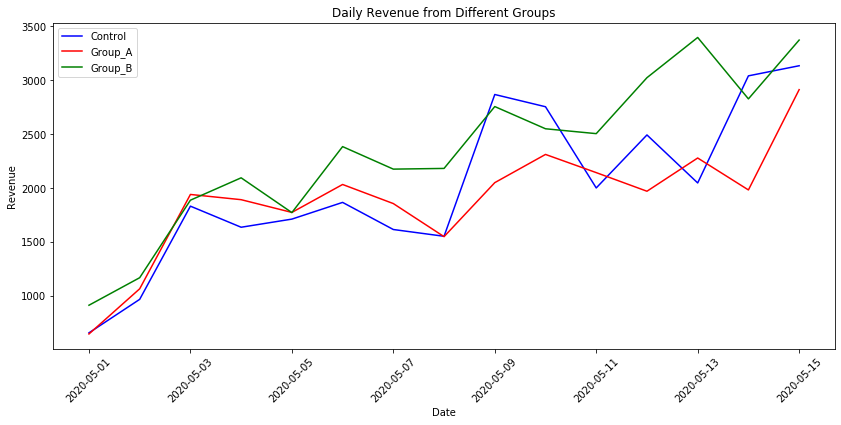

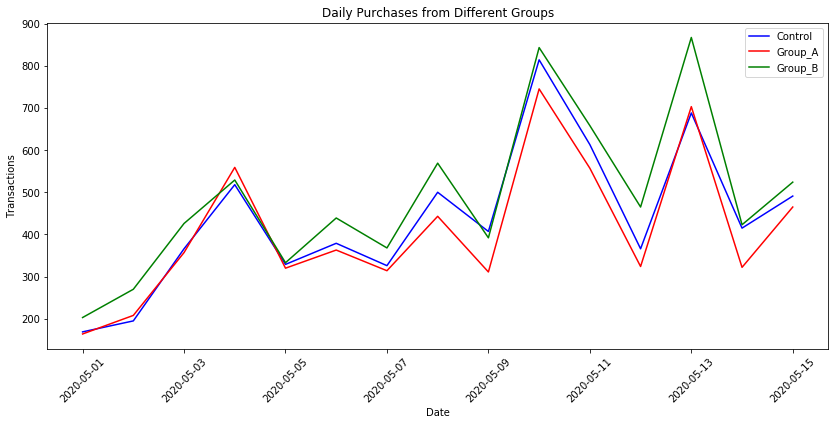

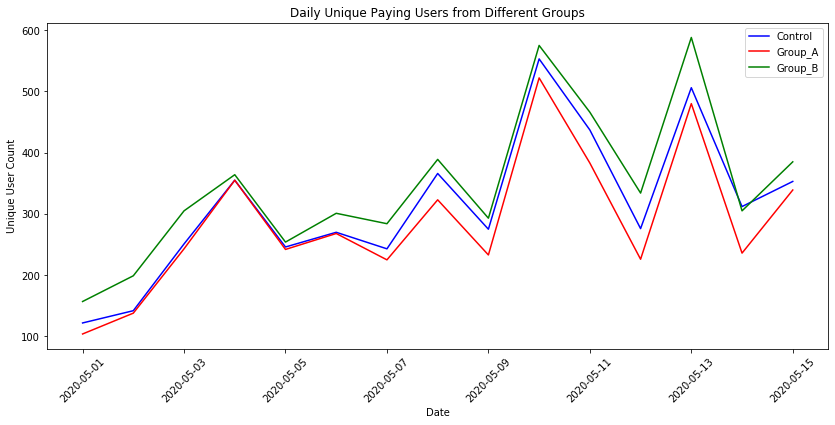

In [29]:
plot_graph(plt_a,'Daily Revenue from Different Groups', 'Revenue')
plot_graph(plt_b,'Daily Purchases from Different Groups', 'Transactions')
plot_graph(plt_c,'Daily Unique Paying Users from Different Groups', 'Unique User Count')

In [30]:
#Explore a bit more
purchases_df.groupby(['aq_date','seniority'])['cost'].sum()

aq_date     seniority
2020-05-01  1            2216.14
            2             902.78
            3            1203.94
            4             510.86
            5             615.29
                          ...   
2020-05-13  2            1700.04
            3             846.35
2020-05-14  1            1365.08
            2            1176.19
2020-05-15  1            2085.57
Name: cost, Length: 121, dtype: float64

In [31]:
purchases_df[purchases_df['seniority']==0]

,index,userId,aq_date,date,abTestGroup,product,cost,seniority
3409,3409,65ui825fvx6is45,2020-05-12,2020-05-11,test_group_b,starterpack1,5.49,0
18538,18538,v132tp2rpk7pekh,2020-05-12,2020-05-11,test_group_b,starterpack1,5.49,0


In [32]:
matches[matches['userId']=='65ui825fvx6is45']

,userId,date,matches
40616,65ui825fvx6is45,2020-05-13,4
120742,65ui825fvx6is45,2020-05-12,7
163352,65ui825fvx6is45,2020-05-15,11


Seems like we have two records where the users purchased something from the store even before playing a game. 
This records are not incorrect but since they are only two we will remove them from our cohort analysis.

In [33]:
purchases_df=purchases_df[purchases_df['seniority']!=0]

Let's calculate the CARPU of the cohorts at different values of N

In [34]:
#Use the cumsum function on a pivot table to calculate cumulative arpus for each cohort
def cohort_carpu(df,base):
    cohort_data = df.groupby(['aq_date', 'seniority'])['cost'].sum()
    cohort_data = cohort_data.reset_index()
    cohort_revenue = cohort_data.pivot(index='aq_date', columns='seniority', values='cost')
    return cohort_revenue.cumsum(axis=1).divide(base, axis=0).round(3)

In [35]:
a_carpu=cohort_carpu(purchases_df[purchases_df['abTestGroup']=='test_group_a'], a_counts[1])
b_carpu=cohort_carpu(purchases_df[purchases_df['abTestGroup']=='test_group_b'], b_counts[1])
c_carpu=cohort_carpu(purchases_df[purchases_df['abTestGroup']=='control_group'], c_counts[1])

In [36]:
#calculate the % difference in cumulative arpu between different groups
diff_a=round(((a_carpu-c_carpu)/c_carpu),2)
diff_b=round(((b_carpu-c_carpu)/c_carpu),2)


In [37]:
#Mean diff in CARPU at day 1
print(diff_a[2].mean())
print(diff_b[2].mean())
#Mean diff in CARPU at day 7
print(diff_a[8].mean())
print(diff_b[8].mean())

-0.07785714285714285
0.36071428571428565
-0.0012500000000000011
0.19125


In [38]:
#function to plot a heatmap which shows percentage differences
def plot_heatmap(pivot,color):
    plt.figure(figsize=(14,10))
    plt.title('% difference in Cumulative ARPU')
    ax = sns.heatmap(data=pivot, annot=True, fmt='.0%', vmin=0.0, vmax=1,cmap=color)
    ax.set_yticklabels(pivot.index)
    fig=ax.get_figure()
    fig.savefig("CARPU.png")
    plt.show()

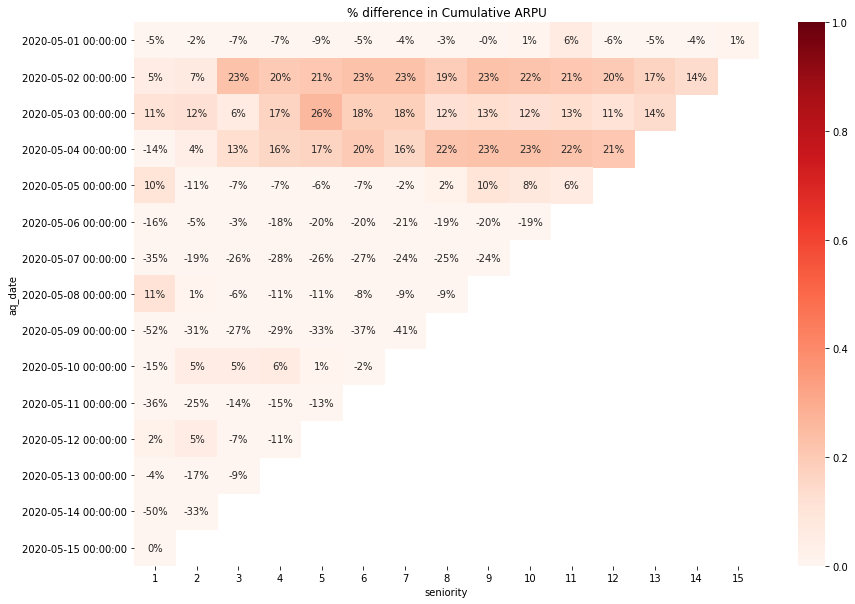

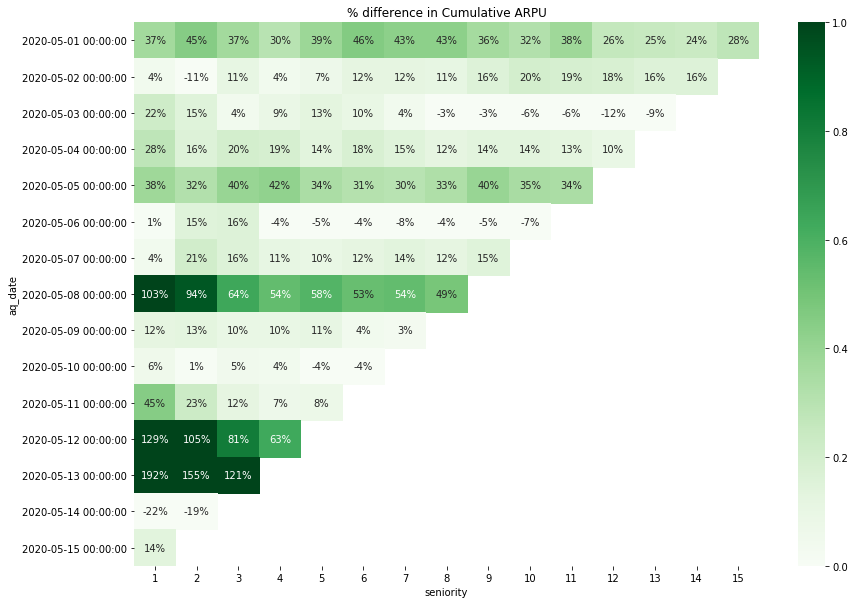

In [39]:
plot_heatmap(diff_a,'Reds')
plot_heatmap(diff_b,'Greens')


We'll now only look at the first purchase made by each user to look at conversion rates. 

In [40]:
#Add first purchase and then drop duplicates
uniq_purchase=purchases_df.copy()
uniq_purchase.set_index('userId', inplace=True, drop=False)
uniq_purchase['first_purchase'] = uniq_purchase.groupby(level=0)['date'].min()
uniq_purchase=uniq_purchase.drop_duplicates(subset=['userId','aq_date','abTestGroup','first_purchase'])

In [41]:
#add acquisition date
uniq_purchase.aq_date = pd.to_datetime(uniq_purchase.aq_date, format='%Y-%m-%d')
uniq_purchase.date = pd.to_datetime(uniq_purchase.first_purchase, format='%Y-%m-%d')
uniq_purchase['seniority'] = (uniq_purchase['first_purchase'] - uniq_purchase['aq_date']).dt.days + 1

In [42]:
#function to calculate cumulative conversion rate. We'll use the cumsum() function again
def cohort_ccr(df,base):
    ccr_data = df.groupby(['aq_date', 'seniority'])['userId'].size()
    ccr_data = ccr_data.reset_index()
    ccr_counts = ccr_data.pivot(index='aq_date', columns='seniority', values='userId')
    ccr= ccr_counts.cumsum(axis=1).divide(base, axis=0).round(3)
    return ccr

In [43]:
ccr_a=cohort_ccr(uniq_purchase[uniq_purchase['abTestGroup']=='test_group_a'],a_counts[1])
ccr_b=cohort_ccr(uniq_purchase[uniq_purchase['abTestGroup']=='test_group_b'],b_counts[1])
ccr_c=cohort_ccr(uniq_purchase[uniq_purchase['abTestGroup']=='control_group'],c_counts[1])


In [44]:
diff_a=round(((ccr_a-ccr_c)/ccr_c),2)
diff_b=round(((ccr_b-ccr_c)/ccr_c),2)

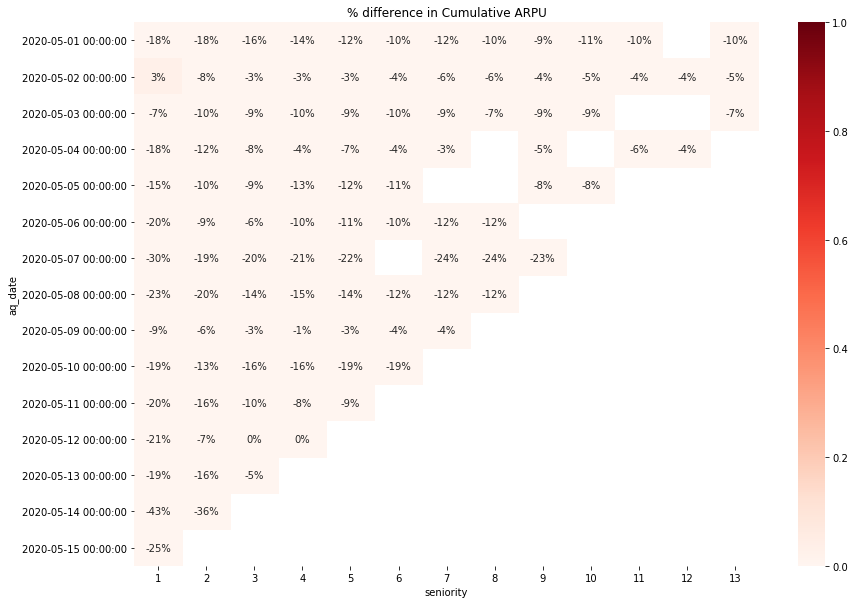

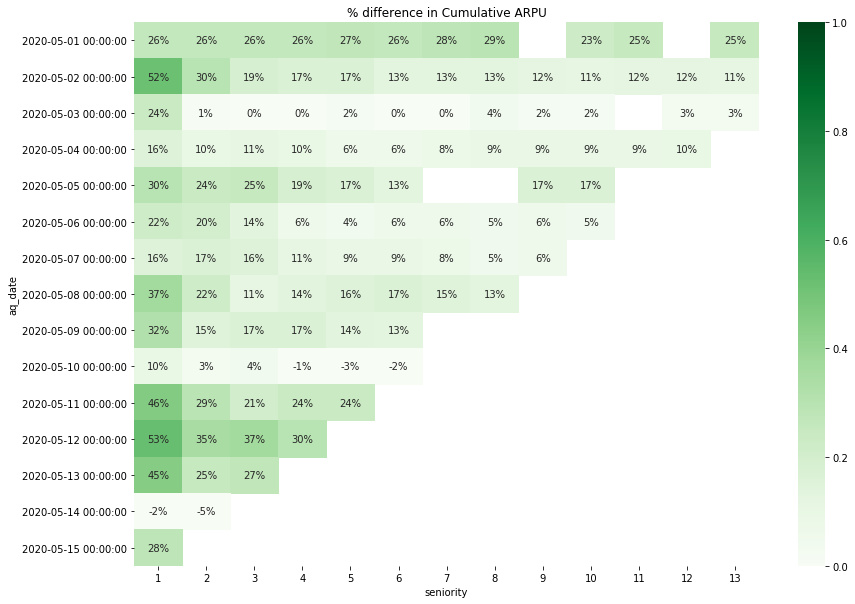

In [45]:
plot_heatmap(diff_a,'Reds')
plot_heatmap(diff_b,'Greens')

In [46]:
#Mean diff in CCR at day 1
print(diff_a[2].mean())
print(diff_b[2].mean())
#Mean diff in CCR at day 7
print(diff_a[8].mean())
print(diff_b[8].mean())

-0.14285714285714285
0.18
-0.11833333333333333
0.11142857142857143


In [47]:
#Mean diff in CCR at day 7
print(diff_a[13].mean())
print(diff_b[13].mean())

-0.07333333333333335
0.13


The next metric to look at is the cumulative arpu per paying user. We divide the cumulative revenue with the number of paying users

In [48]:
##CARPPU
paying_users=ccr_a.multiply(a_counts[1],axis=0)
c_revenue=a_carpu.multiply(a_counts[1],axis=0)
carppu_a=round(c_revenue/paying_users)


paying_users=ccr_b.multiply(b_counts[1],axis=0)
c_revenue=b_carpu.multiply(b_counts[1],axis=0)
carppu_b=round(c_revenue/paying_users)

paying_users=ccr_c.multiply(c_counts[1],axis=0)
c_revenue=c_carpu.multiply(c_counts[1],axis=0)
carppu_c=round(c_revenue/paying_users)

In [49]:
diff_a=round(((carppu_a-carppu_c)/carppu_c),2)
diff_b=round(((carppu_b-carppu_c)/carppu_c),2)

#Mean diff in CARPPU at day 1
print(diff_a[2].mean())
print(diff_b[2].mean())
#Mean diff in CARPPU at day 7
print(diff_a[8].mean())
print(diff_b[8].mean())

#Mean diff in CARPPU at day 12
print(diff_a[13].mean())
print(diff_b[13].mean())

0.0792857142857143
0.13071428571428573
0.07833333333333334
0.052857142857142846
0.17333333333333334
-0.023333333333333334
